# HAT-P-12

In [1]:
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt

In [2]:
name = 'HAT-P-12'

In [3]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))
obs = om.Observation.from_files(fnames)

In [4]:
obs

HAT-P-12 [2 Visits]

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

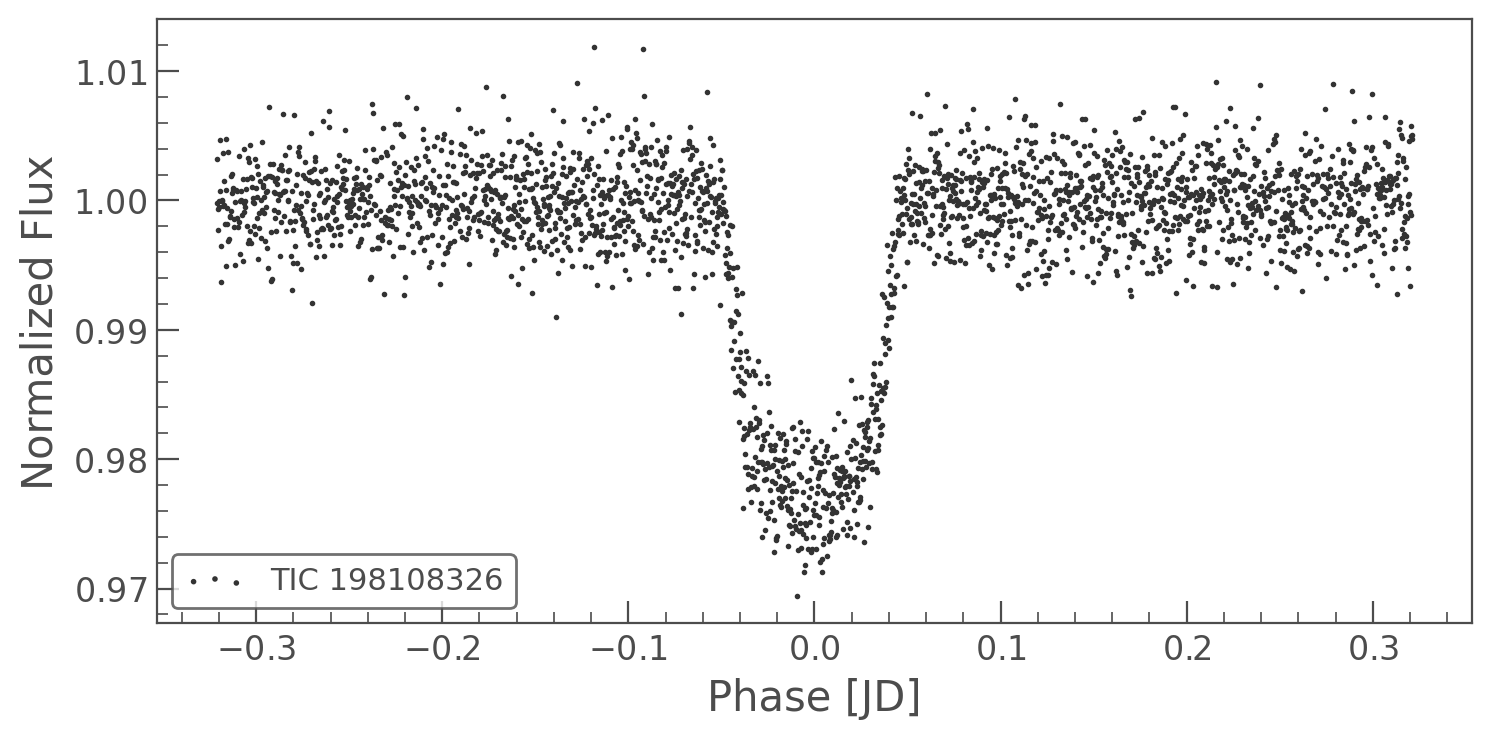

In [5]:
import lightkurve as lk
import astropy.units as u
clc = lk.search_lightcurve(name, author='SPOC', exptime=120).download_all().stitch().remove_nans().flatten(1501, sigma=2)
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s
k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()

In [6]:
obs.fit_transit(x_suppl=clc.time.value + 2457000,
                y_suppl=clc.flux.value/np.median(clc.flux.value),
                yerr_suppl=clc.flux_err.value/np.median(clc.flux.value),
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=True, fit_inc=True)

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

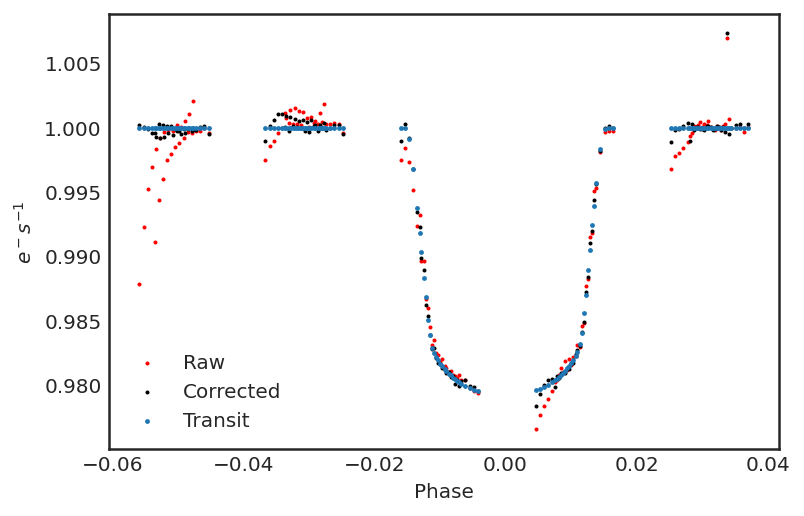

In [7]:
obs.plot()

In [8]:
obs.fit_model()

Fitting Transit/Eclipse Model:   0%|          | 0/2 [00:00<?, ?it/s]

Fitting Transit/Eclipse Model:  50%|█████     | 1/2 [00:06<00:06,  6.26s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 2/2 [00:13<00:00,  6.70s/it]

Fitting Transit/Eclipse Model: 100%|██████████| 2/2 [00:13<00:00,  6.64s/it]

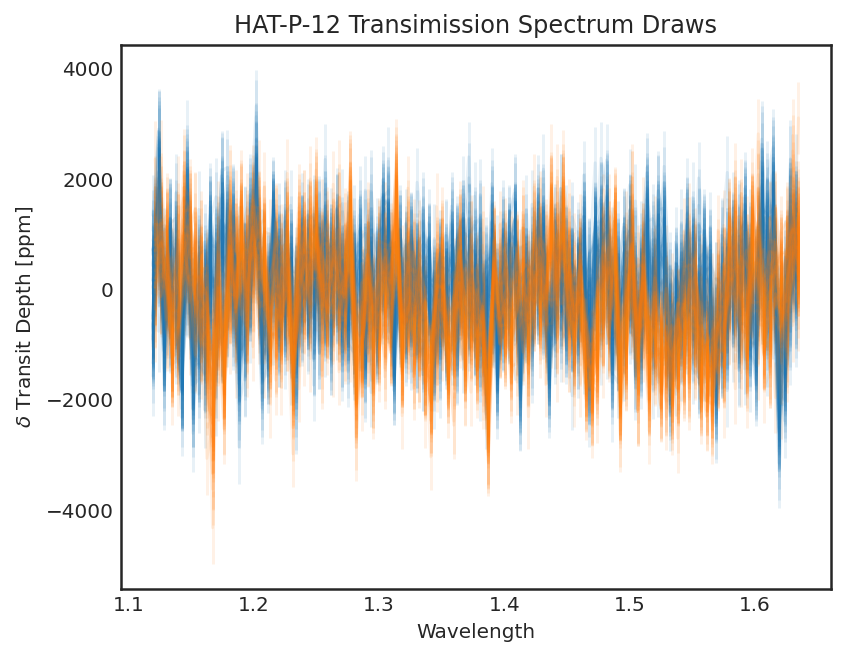

In [9]:
obs.plot_spectra()

<AxesSubplot:title={'center':'HAT-P-12 Transmission Spectrum, Visit: 1'}, xlabel='Wavelength', ylabel='$\\delta$ Transit Depth [ppm]'>

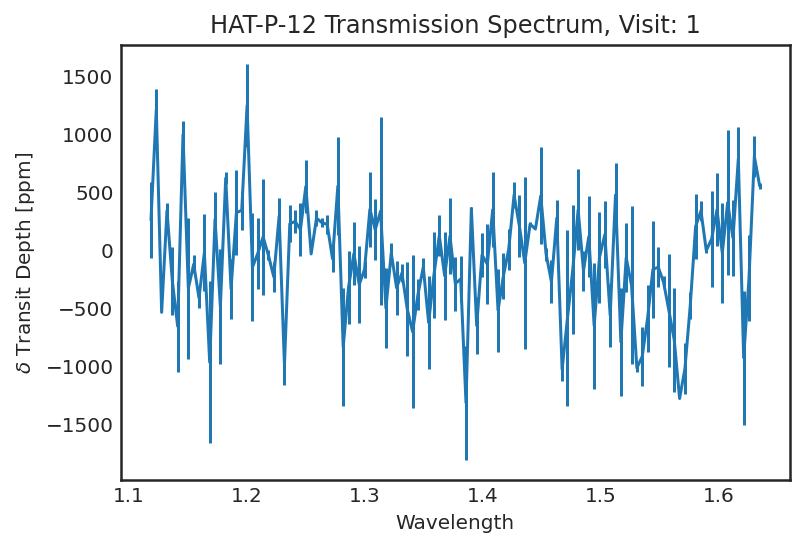

In [10]:
om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 200)).plot()

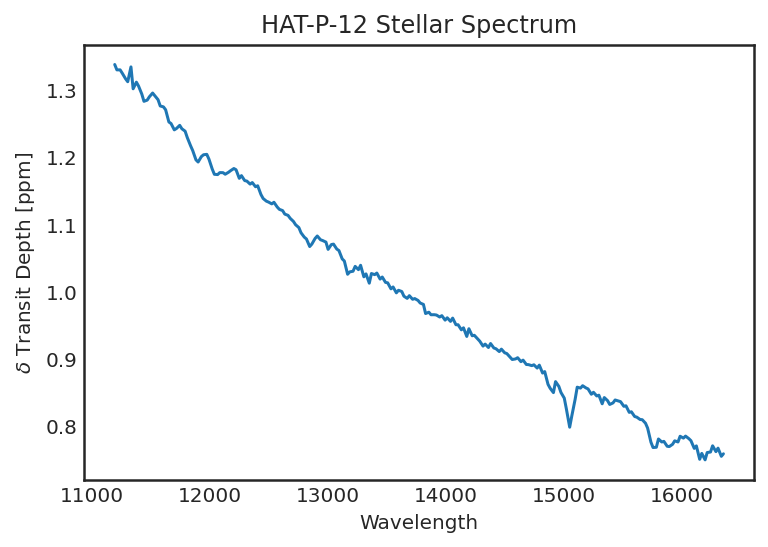

In [11]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

In [12]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits', overwrite=True)
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits', overwrite=True)
except:
    pass

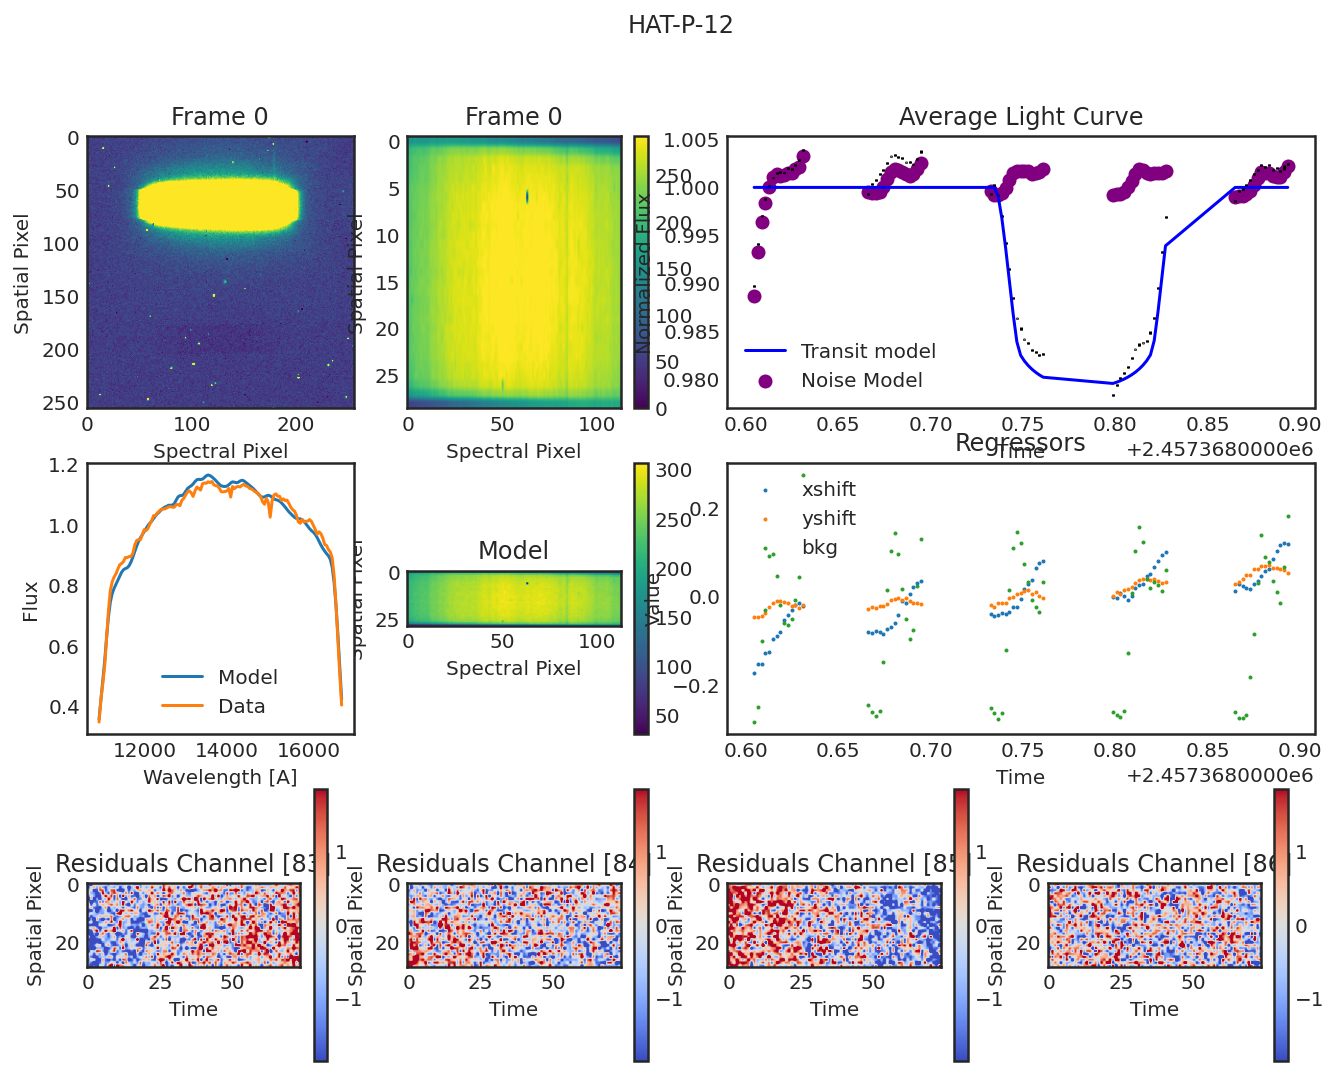

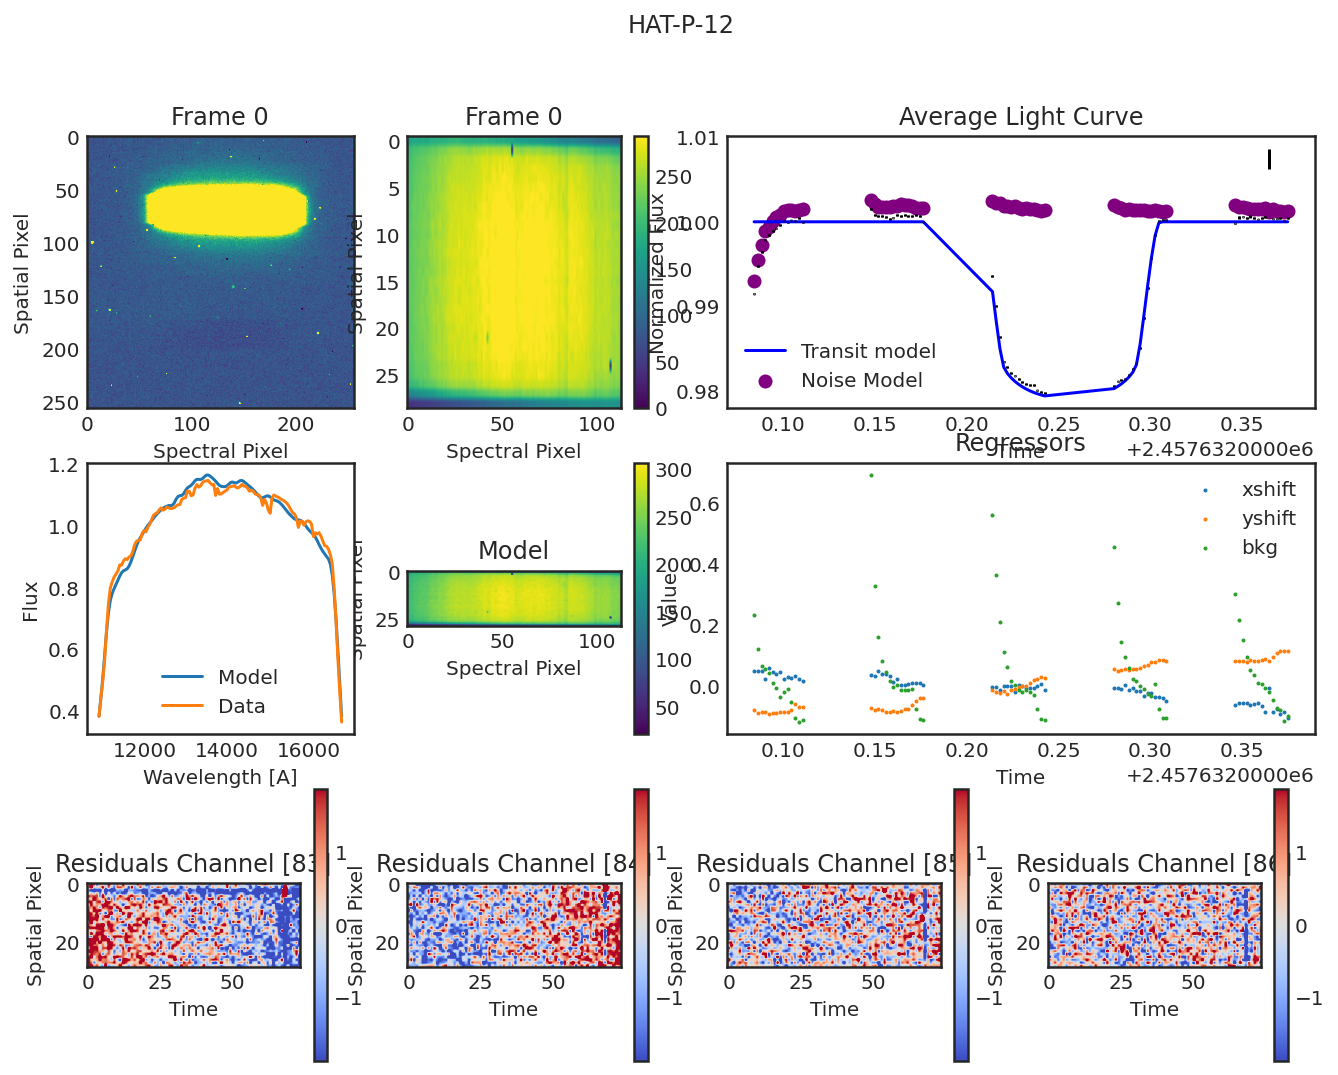

In [13]:
for visit in obs:
    visit.diagnose();
    plt.show();